In [63]:
import os
import torch
import torchvision

import statistics
import h5py
import copy
import cv2
import deepdish as dd

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
from sklearn.metrics import roc_auc_score
from skimage import measure

import sklearn.metrics as metrics
import numpy as np
from sklearn.metrics import roc_curve, auc, jaccard_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


import tempfile
import time
import pickle as pkl;

import data.constants.constants as constants

In [8]:
n_epochs = 50
patience_limit = 20
patience = 0
batch_size_train = 4# was 64
batch_size_test = 4
learning_rate = 0.001
momentum = 0.1
log_interval = 31
tt_factor = 0.8
orientation = 'AP'
num_imgs = 5000

model_path = './data/saved_models/' + 'all_diseases_all_imgs' + '.pth'

random_seed = 1
#torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [50]:
dis_small_map = {'Cardiomegaly': 0, 'Effusion': 1, 'Mass': 2, 'Nodule': 3, 'Atelectasis': 4}

In [11]:
pkl_load = open('dataset_bb.pickle', 'rb')
data_bb = pkl.load(pkl_load)
pkl_load.close()
print("data loaded in successfully")

data loaded in successfully


In [13]:
# transforms = [torchvision.transforms.ToTensor()] # no longer grayscale conversion
# #0 = train, 1 = test
# dataset_train = GetLoader_w_val(data_bb, orientation, list(['Cardiomegaly', 'Effusion', 'Mass', 'Nodule', 'Atelectasis', 'No Finding']),
#                           num_imgs, tt_factor, 0, transforms)
# dataset_valid = GetLoader_w_val(data_bb, orientation, list(['Cardiomegaly', 'Effusion', 'Mass', 'Nodule', 'Atelectasis', 'No Finding']),
#                           num_imgs, tt_factor, 1, transforms)
# dataset_test = GetLoader_w_val(data_bb, orientation, list(['Cardiomegaly', 'Effusion', 'Mass', 'Nodule', 'Atelectasis', 'No Finding']),
#                           num_imgs, tt_factor, 2, transforms)
# print(len(dataset_train))
# print(len(dataset_valid))
# print(len(dataset_test))

In [14]:
# train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size_train, shuffle=True, num_workers=1)
# test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size_train, shuffle=True, num_workers=1)
# valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size_train, shuffle=True, num_workers=1)
# print(len(train_loader))
# print(len(valid_loader))
# print(len(test_loader))

In [15]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)

Using cache found in /home/npp002/.cache/torch/hub/pytorch_vision_v0.6.0


In [16]:
model.fc = nn.Sequential(*[
    nn.Linear(in_features=512, out_features=6, bias=True),
    nn.Sigmoid(),
])
model = torch.nn.DataParallel(model)

In [17]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [18]:
network = model
#network = torchvision.models.vgg11(pretrained=False)
#network.fc = nn.Linear(512, 15)
network.cuda()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
print('Trainable params: {}'.format(sum(p.numel() for p in network.parameters() if p.requires_grad)))

Trainable params: 11179590


In [19]:
class ResNet(nn.Module):
    def __init__(self, model_file):
        super(ResNet, self).__init__()
        
        self.model_file = model_file
        
        self.model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)
        self.model.fc = nn.Sequential(*[
            nn.Linear(in_features=512, out_features=6, bias=True),
            nn.Sigmoid()
        ])
        
        self.features_conv = nn.Sequential(*list(self.model.children())[:-2])
        self.global_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.classifier =  nn.Sequential(*list(self.model.children())[-2:][1:])
        
        self.gradients = None
        
    def load_weights(self):
        self.model = torch.nn.DataParallel(self.model)
        self.model.load_state_dict(torch.load(self.model_file))
    
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)

        h = x.register_hook(self.activations_hook)

        x = self.global_pool(x)
        x = x.view(1, -1)    
        x = self.classifier(x)
        
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features_conv(x)

In [20]:
gmodel = ResNet(model_path)

Using cache found in /home/npp002/.cache/torch/hub/pytorch_vision_v0.6.0


In [21]:
gmodel.load_weights()
print('weights loaded successfully')

In [51]:
def check_contains(b1, b2):
    lx = b1['low_x'] <= b2['low_x']
    ly = b1['low_y'] <= b2['low_y']
    hx = b1['high_x'] >= b2['high_x']
    hy = b1['high_y'] >= b2['high_y']
    
    return lx and ly and hx and hy


In [52]:
def check_too_big(b):
    w = b['high_x'] - b['low_x']
    h = b['high_y'] - b['low_y']
    
    return w * h > 350000 # roughly if box is larger than 1/3 of the image then get rid of it

In [64]:
def compute_dist(b, avg):
    x = b['high_x'] - b['low_x']
    y = b['high_y'] - b['low_y']
    return abs(x * y - avg)

In [100]:
def get_bboxes(label_map, disease):
    uniques = np.unique(label_map)
    boxes = {} # stored as x1, x2, y1, y2
    
    #explore_map = copy.deepcopy()
    
    for u in uniques:
        low_x = 9999
        low_y = 9999
        high_x = -1
        high_y = -1
        
        for r in range(len(label_map)):
            for c in range(len(label_map[0])):
                
                cur = label_map[r][c]
                
                if cur == u:
                    low_x = min(low_x, c)
                    low_y = min(low_y, r)
                    high_x = max(high_x, c)
                    high_y = max(high_y, r)
                    
                    #explore_map = 1
                    
        boxes[u] = {'low_x' : low_x, 'low_y' : low_y,
                        'high_x' : high_x, 'high_y' : high_y}
     
    # step 1: remove the boxes that are too big    
    boxes_temp = copy.deepcopy(boxes)
    for k, b in boxes.items():
        if check_too_big(b):
            boxes_temp.pop(k, None)
            
    boxes = boxes_temp
    
    # step 2: remove boxes that are contained in other boxes
    boxes_temp = copy.deepcopy(boxes)

    for k1, b1 in boxes.items():
        for k2, b2 in boxes.items():
            if k1 != k2 and check_contains(b1,b2):
                boxes_temp.pop(k2, None)
                    
    boxes = boxes_temp
    boxes_temp = {}
    
    # step 3: select the 3 boxes with the size closest to that of the average box size for this disease (based on training data)
    avg_size = constants.BBOX_AVG_SIZE[disease]
    
    box_dist_from_avg = {}
    best_boxes = {}
    for k, b in boxes.items():
        box_dist_from_avg[k] = compute_dist(b, avg_size)
        
    box_dist_from_avg = {k : v for k, v in sorted(box_dist_from_avg.items(), key=lambda x: x[1])}
    
    for i, k in enumerate(box_dist_from_avg.keys(), 1):
        best_boxes[k] = boxes[k]
        
        if i == 3: # take only the best 3
            break
        
    boxes = best_boxes
    '''
    I have a dict of the boxes
    for each box, I can compute the size and dist from avg and associate it with box key (via function)
    - then sort the boxes by size
    - keep the top 3 best
    '''
    
    #step 4: reset the keys on the boxes, for ex:  [5, 7, 11] --> [0, 1, 2]
    idx = 0
    for k in boxes.keys():
        boxes_temp[idx] = boxes[k]
        idx += 1
        
    boxes = boxes_temp
        
    #print('\n boxes delivered: \n', boxes)
    return boxes

In [101]:
def get_grad_map(data, model, disease):
    img_path = './data/sorted_images/' + data['disease'] + '/' + data['view'] + '/' + data['img_name']

    transform = torchvision.transforms.ToTensor()
    img = Image.open(img_path).convert('RGB')
    img = transform(img)
    img.shape
    img = img.unsqueeze(dim=0)
    img = img.cuda();
    
    model.eval()

    pred = model(img)
    pred[0][dis_small_map[disease]].backward()
    
    gradients = model.get_activations_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3]) 
    activations = model.get_activations(img).detach() 

    for i in range(512):
        activations[:, i, :, :] *= pooled_gradients[i]
        
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = heatmap.cpu()
    heatmap /= torch.max(heatmap)
    #plt.matshow(heatmap)
    
    grad_activations = heatmap
    
    img = cv2.imread(img_path)
    heatmap = cv2.resize(np.float32(heatmap), (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    
    colormap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = colormap * 0.4 + img
    cv2.imwrite('./map.jpg', superimposed_img)
    
    blobs = heatmap > 160 #* heatmap.mean()
        
    all_labels = measure.label(blobs)
    
    return all_labels, blobs, grad_activations

In [102]:
def calc_iobb(data, model, disease):
    label_map, _, _ = get_grad_map(data, model, disease)
    
    boxes = get_bboxes(label_map, disease)
    
    
    single_level = np.array(label_map >= 1, dtype='int')
    # convert all labels on prediction to same value of '1' for present and '0' for not present
    real_box = np.zeros((1024, 1024), dtype='int')
    x = int(data['x'])
    y = int(data['y'])
    width = int(data['width'])
    height = int(data['height'])
    for xi in range(x, x + width):
        for yi in range(y, y + height):
            real_box[yi][xi] = 1

    pred_boxes = np.zeros((1024, 1024), dtype='int')
    for _, b in boxes.items():
        for xi in range(b['low_x'], b['high_x']+1):
            for yi in range(b['low_y'], b['high_y']+1):
                pred_boxes[yi][xi] = 1
                
#     plt.figure()
#     plt.imshow(real_box)
#     plt.figure()
#     plt.imshow(pred_boxes)
    return jaccard_score(real_box.flatten(), pred_boxes.flatten())
    

In [103]:
def bbox_main(data, model, disease):
        
    all_labels, blobs, grad_activations = get_grad_map(data, model, disease)
    
    plt.figure()
    plt.imshow(grad_activations)
    plt.figure()
    plt.imshow(all_labels)
    
    boxdict = get_bboxes(all_labels, disease)
    
    plt_image = cv2.imread('./map.jpg')
    plt_image = cv2.cvtColor(plt_image, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots()
    ax.imshow(plt_image)
    
    for i in range(len(boxdict)):
        x = boxdict[i]['low_x']
        y = boxdict[i]['low_y']
        width = boxdict[i]['high_x'] - x
        height = boxdict[i]['high_y'] - y
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none' )
        ax.add_patch(rect)
    rect = patches.Rectangle((data['x'], data['y']), data['width'], data['height'], linewidth=2, edgecolor='blue', facecolor='none' )
    ax.add_patch(rect)
    
    print('IoBB = ', calc_iobb(data, model, disease))

IoBB =  0.14692912830281865


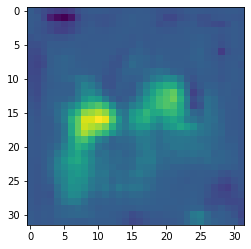

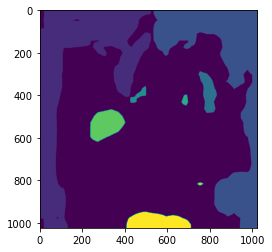

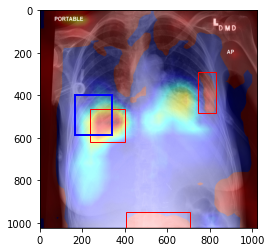

In [104]:
bbox_main(data_bb['AP']['Effusion'][11], gmodel, 'Effusion')

In [32]:
iobb_vals = []
for i in range(14):
    if i not in [13, 15]:
        iobb_vals.append(calc_iobb(data_bb['AP']['Effusion'][i], gmodel, 'Effusion'))
        print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12


In [58]:
''' compute average size of boxes for each class:'''
def calc_area(d):
    return d['width'] * d['height']

avgs = copy.deepcopy(dis_small_map)
count = 0
for dis in dis_small_map.keys():
    avgs[dis] = 0
    for data_item in data_bb['AP'][dis]:
        avgs[dis] += calc_area(data_item)  
    avgs[dis] /= len(data_bb['AP'][dis])          

In [59]:
avgs

{'Cardiomegaly': 184334.51389042215,
 'Effusion': 72002.74056476016,
 'Mass': 44378.91808337311,
 'Nodule': 5468.77115036753,
 'Atelectasis': 33508.51688697086}

In [21]:
pkl_load = open('./dataset_bb.pickle', 'rb')
data_bb = pkl.load(pkl_load)
pkl_load.close()
print("dataset for bounding box loaded in successfully")

dataset for bounding box loaded in successfully


In [46]:
bbox_results = {'AP' : {}, 'PA' : {}}

bbox_results['AP'] =  {'Cardiomegaly': [], 'Effusion': [], 'Mass': [], 'Nodule': [], 'Atelectasis': []}
bbox_results['PA'] =  {'Cardiomegaly': [], 'Effusion': [], 'Mass': [], 'Nodule': [], 'Atelectasis': []}

In [56]:
for view in data_bb.keys():
    for disease in bbox_results['AP'].keys():
        for i in range(len(data_bb[view][disease])):
            bbox_results[view][disease].append(compute_bbox_iou(data_bb[view][disease][i], gmodel, disease))
        print(view, disease, 'complete')

AP Cardiomegaly complete
AP Effusion complete
AP Mass complete
AP Nodule complete
AP Atelectasis complete
PA Cardiomegaly complete
PA Effusion complete
PA Mass complete
PA Nodule complete
PA Atelectasis complete


In [48]:
data_bb.keys()

dict_keys(['AP', 'PA'])

In [57]:
for view in bbox_results.keys():
    for disease in bbox_results[view].keys():
        if bbox_results[view][disease]:
            mean = statistics.mean(bbox_results[view][disease])
            bbox_results[view][disease].sort()
            median = bbox_results[view][disease][len(bbox_results[view][disease]) // 2]
        print(view, disease, mean, median)
        print()

AP Cardiomegaly 0.1487217804768757 0.14913752590260934

AP Effusion 0.06917364005319358 0.05750243878191387

AP Mass 0.0336113380663053 0.015747674109975206

AP Nodule 0.00507850780219051 0.0043152350081037275

AP Atelectasis 0.03163882096697622 0.01921908096527521

PA Cardiomegaly 0.1487217804768757 0.14913752590260934

PA Effusion 0.06917364005319358 0.05750243878191387

PA Mass 0.0336113380663053 0.015747674109975206

PA Nodule 0.00507850780219051 0.0043152350081037275

PA Atelectasis 0.03163882096697622 0.01921908096527521



In [ ]:
'''
restructure:
compute iobb and gen bbox could go in the same function together
should all be 1 big thing

main
- generic stuff shared
- print out iobb
- display graph
'''